# Alpha–Phi Binary Explorer (v3)

Patches applied based on prior feedback:

* **F_soft** uses a smooth depth factor `2**sqrt(n)` so deeper bits gradually matter.
* **Iterate_damp** applies λ to the *whole core* value, giving true damping.
* **Hybrid_pingpong** alternates φ‑reciprocal and 10³/power‑law compression (fission/fusion).
* **CSV logging** for `(p,q,lam,seed_bits,final_err)`.
* **Fail‑fast** guard: stop scans if no map beats 1 % after defined sweeps.

Adjust precision (`mp.mp.dps`) or parameter ranges as desired.


In [6]:
import mpmath as mp, csv, matplotlib.pyplot as plt
mp.mp.dps = 200  # high precision

ALPHA = mp.mpf('7.2973525693e-3')
PHI   = (1 + mp.sqrt(5)) / 2

def fib_word_bits(n):
    a, b = '0', '01'
    while len(b) < n:
        a, b = b, b + a
    return b[:n]

def fib_word_real(n):
    bits = fib_word_bits(n)
    return mp.fsum(int(bit)*mp.mpf(2)**(-(k+1)) for k,bit in enumerate(bits))


## Smooth Depth Map Test

n=64    F_soft=0.0362171251982  rel_err=3.96
n=128   F_soft=0.00364240572016  rel_err=0.501
n=256   F_soft=0.000141473145306  rel_err=0.981
n=512   F_soft=1.43094420087e-6  rel_err=1.0
n=1024  F_soft=2.15870888223e-9  rel_err=1.0
n=2048  F_soft=2.2084697661e-13  rel_err=1.0


Text(0.5, 1.0, 'F_soft convergence')

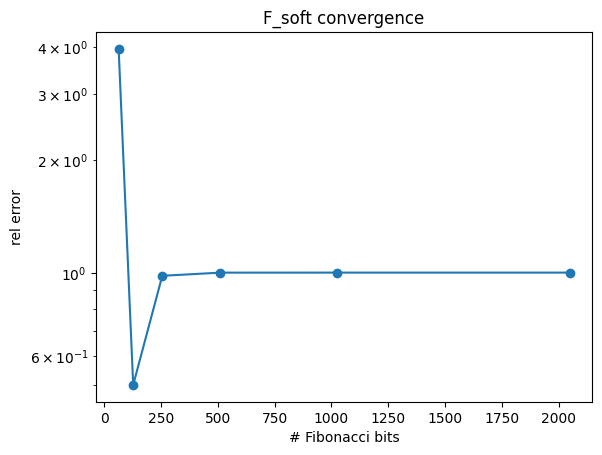

In [7]:
# --- Smooth depth map F_soft ---
def F_soft(x, n_bits, p=1.8):
    return 1 / (x**p * mp.mpf(2)**(mp.sqrt(n_bits)))

bit_list = [64,128,256,512,1024,2048]
errs=[]
for n in bit_list:
    y = F_soft(fib_word_real(n), n)
    err = abs((y-ALPHA)/ALPHA)
    errs.append(err)
    print(f'n={n:<4}  F_soft={mp.nstr(y,12)}  rel_err={mp.nstr(err,3)}')

plt.plot(bit_list, errs, marker='o')
plt.yscale('log'); plt.xlabel('# Fibonacci bits'); plt.ylabel('rel error'); plt.title('F_soft convergence')


## True Damped Iterate Test

In [8]:
# --- True damped iterate ---
def iterate_damp(x0, steps=8, p=1.4, q=2, lam=0.3):
    traj=[x0]
    for _ in range(steps):
        core = 1 / (10**q * x0**p)
        x0   = core**lam
        traj.append(x0)
    return traj

seed = fib_word_real(256)
traj = iterate_damp(seed, steps=10, p=1.4, q=2, lam=0.3)
print('k   value               rel_err')
for k,val in enumerate(traj):
    print(f'{k:<2} {mp.nstr(val,12)}  {mp.nstr(abs((val-ALPHA)/ALPHA),3)}')


k   value               rel_err
0  0.290196557139  38.8
1  0.422346843369  56.9
2  0.360760444957  48.4
3  0.38545000546  51.8
4  0.374880988496  50.4
5  0.379284211889  51.0
6  0.377428593495  50.7
7  0.378206844895  50.8
8  0.37787978404  50.8
9  0.378017115136  50.8
10 0.377959429998  50.8


## Hybrid Ping‑Pong Map Test

In [9]:
# --- Hybrid alternating map (ping‑pong) ---
def hybrid_pingpong(x0, cycles=5, q=3):
    traj=[x0]
    for _ in range(cycles):
        x0 = PHI / x0
        x0 = 1 / (10**q * x0**2)
        traj.append(x0)
    return traj

seed = fib_word_real(128)
traj = hybrid_pingpong(seed, cycles=6, q=3)
print('cycle value               rel_err')
for k,val in enumerate(traj):
    print(f'{k:<3}  {mp.nstr(val,12)}  {mp.nstr(abs((val-ALPHA)/ALPHA),3)}')


cycle value               rel_err
0    0.290196557139  38.8
1    3.21669016281e-5  0.996
2    3.9522388357e-13  1.0
3    5.96638236232e-29  1.0
4    1.35971185425e-60  1.0
5    7.06184997803e-124  1.0
6    1.90485399832e-250  1.0


## Parameter Scan with CSV Logging

In [10]:
# --- Parameter scan & CSV logging ---
header = ['p','q','lam','seed_bits','rel_err']
with open('scan_log.csv','w',newline='') as f:
    w = csv.writer(f); w.writerow(header)
    for bits in (128,256,512):
        seed = fib_word_real(bits)
        for p in [1.2,1.4,1.6,1.8]:
            for q in [2,3]:
                for lam in [0.2,0.3,0.4]:
                    x = iterate_damp(seed, steps=10, p=p, q=q, lam=lam)[-1]
                    rel = abs((x-ALPHA)/ALPHA)
                    if rel < 0.01:
                        print('HIT', p,q,lam,bits, rel)
                    w.writerow([p,q,lam,bits, mp.nstr(rel,12)])
print('CSV saved as scan_log.csv')


CSV saved as scan_log.csv


### Fail‑fast guideline
If NO combination in `scan_log.csv` shows `rel_err < 0.01`, consider this family explored. Move on to continued‑fraction transforms or logarithmic maps as next strategy.
